In [1]:
import numpy as np
c = 299792458
#from direction_rotate import _calc_rotation_mats
import matplotlib.pyplot as plt


import xarray as xr
import dask.array as da
import cngi.conversion.convert_ms as convert_ms
import cngi.conversion.convert_image as convert_image
from cngi.dio import read_vis
import numpy as np
from astropy.coordinates import SkyCoord
from sirius import calc_vis
from astropy.wcs import WCS
import time
deg_to_rad = np.pi/180
from sirius import make_ant_sky_jones, simulation
from sirius._sirius_utils._ant_jones_term import _compute_rot_coords
from sirius._sirius_utils._calc_parallactic_angles import _calc_parallactic_angles, _find_optimal_set_angle

from astropy.time import Time
from astropy.coordinates import (EarthLocation, SkyCoord,
                                 AltAz, CIRS)
import astropy.units as u

import pkg_resources

In [2]:
tel_dir = pkg_resources.resource_filename('casadata', 'data/telescope_layout/data/vla.d.tel.zarr')
#tel_xds = xr.open_zarr(tel_dir)


mxds = read_vis('point_source_sim_vis/mosaic_pleiades_sim_dovp_True.vis.zarr')


mxds.attrs['xds0'] = mxds.attrs['xds0']#.isel(time=slice(80,81))
print(mxds.xds0.time)
#(_)_s dimension can be singleton (value is reused)

<xarray.DataArray 'time' (time: 350)>
array(['2019-10-04T05:48:39.800061184', '2019-10-04T05:54:39.800061184',
       '2019-10-04T06:00:39.800061184', ..., '2019-10-07T10:30:39.800061184',
       '2019-10-07T10:36:39.800061184', '2019-10-07T10:42:39.800061184'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2019-10-04T05:48:39.800061184 ... 2019-10-...


In [3]:
tel_dir

'/users/mbarth/miniconda3/envs/casa_env/lib/python3.7/site-packages/casadata/data/telescope_layout/data/vla.d.tel.zarr'

### Set up parameters for UVW calculation

In [13]:
ant_pos = mxds.ANTENNA.POSITION.values # [n_ant x 3]
time_str = mxds.xds0.time.values        # [n_time]
site = 'VLA'

phase_center_ra_dec = mxds.FIELD.PHASE_DIR.sel(field_id=mxds.xds0.FIELD_ID.isel(baseline=0).values).values[:,0,:] #n_time x 2
#print('phase_center_ra_dec',phase_center_ra_dec)
#print('field ids',mxds.xds0.FIELD_ID.isel(baseline=0).values)

ant1 = mxds.xds0.ANTENNA1.values
ant2 = mxds.xds0.ANTENNA2.values

In [14]:
uvw_parms = {}
uvw_parms['calc_method'] = 'astropy'
uvw_parms['site'] = 'vla'
uvw_parms['auto_corr'] = False

uvw = mxds.xds0.UVW.values
print(uvw.shape)

(350, 351, 3)


In [15]:
airy_disk_parms =  {'pb_func':'casa_airy','dish_diameter':24.5,'blockage_diameter':0.0}
beam_models = [airy_disk_parms]
n_ant = len(ant_pos)
beam_model_map = np.zeros(n_ant,dtype=int)

beam_parms = {}
beam_parms['pa_radius'] = 0.2
beam_parms['mueller_selection'] = np.array([0,15])

freq_chan = mxds.xds0.chan.values
pol = mxds.xds0.pol.values

### Setup Sources

In [16]:
#pointing_ra_dec:  [n_time, n_ant, 2]          (singleton: n_time, n_ant)
pointing_ra_dec = None #np.zeros((1, 1, 2)) #Singleton

#point_source_ra_dec:  [n_time, n_point_sources, 2]          (singleton: n_time)
ra = ['03h47m59.0s', '03h47m29.0s', '03h46m02.9s', '03h45m54.5s', '03h44m48.2s', '03h49m11.2s', '03h45m12.5s', '03h47m29.1s','03h49m09.7s','03h46m19.6s','03h45m49.6s', '03h44m52.5s']
dec = ['+24d29m20.0s', '+24d17m22.2s', '+24d31m40.4s', '+24d33m16.2s', '+24d17m22.1s', '+24d08m12.2s','+24d28m02.2s', '+24d06m18.5s','+24d03m12.3s','+23d56m54.1s','+24d22m03.9s','+24d06m48.0s']
point_source_skycoord = SkyCoord(ra=ra,dec=dec,frame='fk5') #sim

'''
03h47m29.1s +24d06m18.5s
03h49m09.7s +24d03m12.3s
03h46m19.6s +23d56m54.1s
03h45m49.6s +24d22m03.9s
03h44m52.5s +24d06m48.0s
'''
point_source_ra_dec = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad]).T[None,:,:]

In [17]:
point_source_ra_dec.shape

(1, 12, 2)

In [18]:
# NB n_pol is no longer singleton
#point_source_flux: [n_time, n_chan, n_pol, n_point_sources] (singleton: n_time, n_chan)
point_source_flux = np.array([2.17, 0, 0, 2.17])[None,None,:,None] #has to be in instrument polarization: [RR,RL,LR,LL] or [XX,XY,YX,YY]. All 4 values are needed.
point_source_flux = np.tile(point_source_flux,(1,1,1,12))
point_source_flux[:, :, 0, -5:] = 3
point_source_flux[:, :, 3, -5:] = 3
point_source_flux[:, :, 0, -12:-9] = 1
point_source_flux[:, :, 3, -12:-9] = 1
pb_limit = 0.0045

In [19]:
point_source_flux

array([[[[1.  , 1.  , 1.  , 2.17, 2.17, 2.17, 2.17, 3.  , 3.  , 3.  ,
          3.  , 3.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  ],
         [0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
          0.  , 0.  ],
         [1.  , 1.  , 1.  , 2.17, 2.17, 2.17, 2.17, 3.  , 3.  , 3.  ,
          3.  , 3.  ]]]])

In [20]:
vis_data, uvw = simulation(point_source_flux, point_source_ra_dec, pointing_ra_dec, phase_center_ra_dec, beam_parms,beam_models,beam_model_map,uvw_parms, ant_pos, time_str, freq_chan, pol, ant1, ant2, pb_limit, uvw) #None can be changed to uvw

[{'pb_func': 'casa_airy', 'dish_diameter': 24.5, 'blockage_diameter': 0.0}]
pol [5 8]
Completed time step  0 of 350
Completed time step  1 of 350
Completed time step  2 of 350
Completed time step  3 of 350
Completed time step  4 of 350
Completed time step  5 of 350
Completed time step  6 of 350
Completed time step  7 of 350
Completed time step  8 of 350
Completed time step  9 of 350
Completed time step  10 of 350
Completed time step  11 of 350
Completed time step  12 of 350
Completed time step  13 of 350
Completed time step  14 of 350
Completed time step  15 of 350
Completed time step  16 of 350
Completed time step  17 of 350
Completed time step  18 of 350
Completed time step  19 of 350
Completed time step  20 of 350
Completed time step  21 of 350
Completed time step  22 of 350
Completed time step  23 of 350
Completed time step  24 of 350
Completed time step  25 of 350
Completed time step  26 of 350
Completed time step  27 of 350
Completed time step  28 of 350
Completed time step  29 o

In [21]:
casa_vis_data = mxds.xds0.DATA.data.compute()

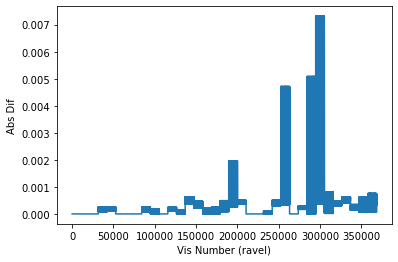

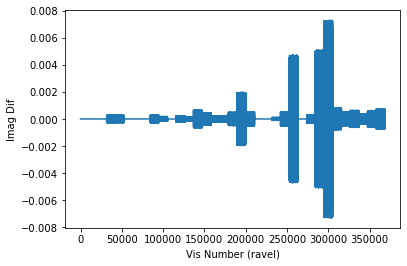

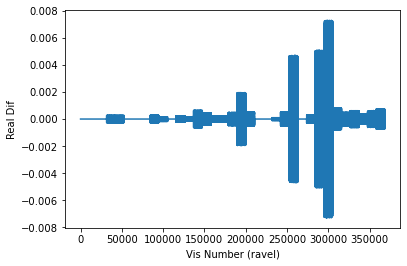

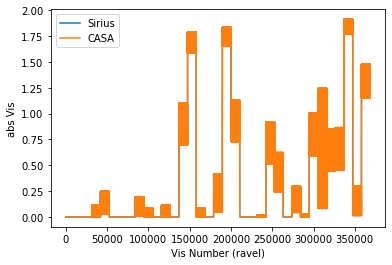

In [109]:
dif = np.ravel((vis_data[:,:,:,0]-casa_vis_data[:,:,:,0])) #/np.abs(casa_vis_data[:,:,:,0])

plt.figure()
plt.plot(np.abs(dif))
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Abs Dif')
plt.show()

plt.figure()
plt.plot(np.imag(dif))
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Imag Dif')
plt.show()

plt.figure()
plt.plot(np.real(dif))
plt.xlabel('Vis Number (ravel)')
plt.ylabel('Real Dif')
plt.show()

plt.figure()
plt.plot(np.abs(np.ravel(vis_data[:,:,:,0])),label='Sirius')
plt.plot(np.abs(np.ravel(casa_vis_data[:,:,:,0])),label='CASA')
plt.legend()
plt.xlabel('Vis Number (ravel)')
plt.ylabel('abs Vis')
plt.show()

### Imaging

In [22]:
from ngcasa.imaging import make_imaging_weight
from ngcasa.imaging import make_image
from ngcasa.imaging import make_pb
from ngcasa.imaging import make_gridding_convolution_function
from cngi.dio import write_image
import dask
import dask.array as da
from ngcasa.imaging import direction_rotate
from cngi.dio import write_image
from ngcasa.imaging import make_image_with_gcf
from ngcasa.imaging import make_mosaic_pb

rad_to_deg =  180/np.pi
deg_to_rad = np.pi/180
arcsec_to_deg = 1/3600
arcsec_to_rad = np.pi/(180*3600)

In [23]:
#mxds = apply_flags(mxds, 'xds0', flags='FLAG')
mxds.attrs['xds1'] = mxds.attrs['xds0'].isel(pol=slice(0,1))
mxds.attrs['xds1']['DATA'] = xr.DataArray(da.from_array(vis_data[:,:,:,0][:,:,:,None],chunks=mxds.attrs['xds1']['DATA'].chunks),coords=mxds.attrs['xds1']['DATA'].coords)

In [24]:
grid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [1600,800]
grid_parms['cell_size'] = [5,5]

point_source_skycoord = SkyCoord(ra='03h47m29.1s',dec='+24d12m18.5s',frame='fk5')
grid_parms['phase_center'] = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])

In [25]:
sel_parms = {}
sel_parms['xds'] = 'xds1' #KEEP USING XDS1 THROUGHOUT
sel_parms['data_group_in_id'] = 0 #CHANGE TO DATA GROUP 2 AFTER ROTATION

rotation_parms = {}
rotation_parms['new_phase_center'] = grid_parms['phase_center']
rotation_parms['common_tangent_reprojection'] = True
rotation_parms['single_precision'] = False

mxds = direction_rotate(mxds, rotation_parms, sel_parms)

######################### Start direction_rotate #########################
Setting data_group_in  to  {'data': 'DATA', 'flag': 'FLAG', 'id': '0', 'uvw': 'UVW', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
######################### Created graph for direction_rotate #########################


In [26]:
imaging_weights_parms = {}
imaging_weights_parms['weighting'] = 'natural'

sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2

mxds = make_imaging_weight(mxds, imaging_weights_parms, grid_parms, sel_parms)

######################### Start make_imaging_weights #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'IMAGING_WEIGHT'}
Since weighting is natural input weight will be reused as imaging weight.
######################### Created graph for make_imaging_weight #########################


In [27]:
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_sel_parms = {}
img_sel_parms['data_group_out_id'] = 0

In [28]:
write_imagegrid_parms = {}
grid_parms['chan_mode'] = 'cube'
grid_parms['image_size'] = [1600,800]
grid_parms['cell_size'] = [5,5]

point_source_skycoord = SkyCoord(ra='03h47m29.1s',dec='+24d12m18.5s',frame='fk5')
grid_parms['phase_center'] = np.array([point_source_skycoord.ra.rad,point_source_skycoord.dec.rad])
gcf_parms = {}
gcf_parms['function'] = 'alma_airy'
gcf_parms['list_dish_diameters'] = np.array([24.5])
gcf_parms['list_blockage_diameters'] = np.array([0])
#gcf_parms['max_support'] = [24, 24]
#gcf_parms['oversampling'] = [10, 10]
gcf_parms['max_support'] = [48, 48]
gcf_parms['oversampling'] = [10, 10]
unique_ant_indx = mxds.ANTENNA.DISH_DIAMETER.values
unique_ant_indx[unique_ant_indx == 25.0] = 0
mxds.ANTENNA.DISH_DIAMETER.values
gcf_parms['unique_ant_indx'] = unique_ant_indx.astype(int)
gcf_parms['phase_center'] = grid_parms['phase_center']
sel_parms = {}
sel_parms['xds'] = 'xds1'
sel_parms['data_group_in_id'] = 2
gcf_xds = make_gridding_convolution_function(mxds, gcf_parms, grid_parms, sel_parms)
dask.compute(gcf_xds)

######################### Start make_gridding_convolution_function #########################
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default chan_tolerance_factor  to  0.005
Setting default support_cut_level  to  0.025
Setting default a_chan_num_chunk  to  3
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
#########################  Created graph for make_gridding_convolution_function #########################


(<xarray.Dataset>
 Dimensions:             (baseline: 351, chan: 3, conv_baseline: 1, conv_chan: 3, conv_pol: 1, field_id: 35, l: 1600, m: 800, pol: 1, u: 490, v: 490, xy: 2)
 Coordinates:
   * u                   (u) int64 0 1 2 3 4 5 6 ... 483 484 485 486 487 488 489
   * v                   (v) int64 0 1 2 3 4 5 6 ... 483 484 485 486 487 488 489
   * xy                  (xy) int64 0 1
   * field_id            (field_id) int64 0 1 2 3 4 5 6 ... 28 29 30 31 32 33 34
   * l                   (l) int64 0 1 2 3 4 5 ... 1594 1595 1596 1597 1598 1599
   * m                   (m) int64 0 1 2 3 4 5 6 ... 793 794 795 796 797 798 799
 Dimensions without coordinates: baseline, chan, conv_baseline, conv_chan, conv_pol, pol
 Data variables:
     SUPPORT             (conv_baseline, conv_chan, conv_pol, xy) int64 35 ... 23
     WEIGHT_CONV_KERNEL  (conv_baseline, conv_chan, conv_pol, u, v) float64 -1...
     PS_CORR_IMAGE       (l, m) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
     CF_BASELINE

In [29]:
img_xds = xr.Dataset() #empty dataset
vis_sel_parms = {}
vis_sel_parms['xds'] = 'xds1'
vis_sel_parms['data_group_in_id'] = 2

img_xds = make_mosaic_pb(mxds,gcf_xds,img_xds,vis_sel_parms,img_sel_parms,grid_parms)

######################### Start make_mosaic_pb #########################
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_in  to  {'id': '0'}
Setting default data_group_out [' pb ']  to  PB
Setting default data_group_out [' weight_pb ']  to  WEIGHT_PB
Setting default data_group_out [' weight_pb_sum_weight ']  to  WEIGHT_PB_SUM_WEIGHT
#########################  Created graph for make_mosaic_pb #########################


In [30]:
vis_select_parms = {}
vis_select_parms['xds'] = 'xds1'
vis_select_parms['data_group_in_id'] = 2

img_select_parms = {}
img_select_parms['data_group_in_id'] = 0
img_select_parms['data_group_out_id'] = 0

norm_parms = {}
norm_parms['norm_type'] = 'flat_sky'

img_xds = make_image_with_gcf(mxds,gcf_xds, img_xds, grid_parms, norm_parms, vis_select_parms, img_select_parms)

######################### Start make_image_with_gcf #########################
Setting default image_center  to  [800 400]
Setting default fft_padding  to  1.2
Setting default single_precision  to  True
Setting data_group_in  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '2', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting default data_group_out  to  {'data': 'DATA_ROT', 'flag': 'FLAG', 'id': '3', 'uvw': 'UVW_ROT', 'weight': 'DATA_WEIGHT', 'imaging_weight': 'DATA_WEIGHT'}
Setting data_group_in  to  {'id': '0', 'pb': 'PB', 'weight_pb': 'WEIGHT_PB', 'weight_pb_sum_weight': 'WEIGHT_PB_SUM_WEIGHT'}
Setting default data_group_out [' pb ']  to  PB
Setting default data_group_out [' weight_pb ']  to  WEIGHT_PB
Setting default data_group_out [' weight_pb_sum_weight ']  to  WEIGHT_PB_SUM_WEIGHT
Setting default data_group_out [' sum_weight ']  to  SUM_WEIGHT
Setting default data_group_out [' image ']  to  IMAGE
grid sizes 1920 960
#########################  Cre

(-0.5, 799.5, 1599.5, -0.5)

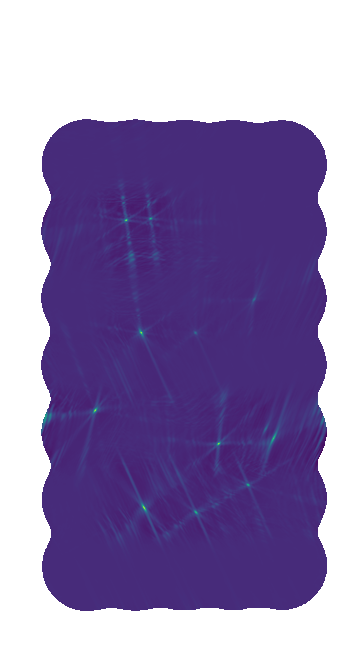

In [59]:
chan = 1
ngcasa_image_name = 'IMAGE'
pb_limit = 0.2
#extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

mosaic_pb = img_xds.PB.isel(chan=chan)
mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
mosaic_img = mosaic_img.where(mosaic_pb > np.max(mosaic_pb)*pb_limit,other=np.nan)

plt.figure(figsize = (12, 12))
#plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))
plt.imshow(mosaic_img[:, :, 0, 0])
plt.axis("off")

In [49]:
from casatools import simulator, image
dovp = True
#gridder = 'standard'
gridder = 'mosaic'
#ms_name = 'zenith_point_source_sim_dovp_' + str(dovp) + '.ms'
#im_name = 'zenith_point_source_sim_img/point_source_sim_dovp_' + str(dovp) + '_gridder_' + gridder

ms_name = 'point_source_sim_vis/mosaic_pleiades_sim_dovp_' + str(dovp) + '.ms'
im_name = 'point_source_sim_img/mosaic_pleiades_sim_dovp_' + str(dovp) + '_gridder_' + gridder
ia = image()
ia.open(im_name+"cniter500.image")
data = ia.getchunk()

In [50]:
chan = 1
ngcasa_image_name = 'IMAGE'
pb_limit = 0.2
#extent = extent=(np.min(casa_img_xds.m),np.max(casa_img_xds.m),np.min(casa_img_xds.l),np.max(casa_img_xds.l))

mosaic_pb = img_xds.PB.isel(chan=chan)
mosaic_img = img_xds[ngcasa_image_name].isel(chan=chan)
mosaic_img = mosaic_img.where(mosaic_pb > np.max(mosaic_pb)*pb_limit,other=np.nan)

In [51]:
data.shape

(1600, 800, 1, 3)

In [52]:
img_xds.PB.shape

(1600, 800, 1, 3, 1)

In [53]:
data1.shape

(1600, 800)

In [54]:
pb1.shape

(1600, 800)

(-0.5, 799.5, 1599.5, -0.5)

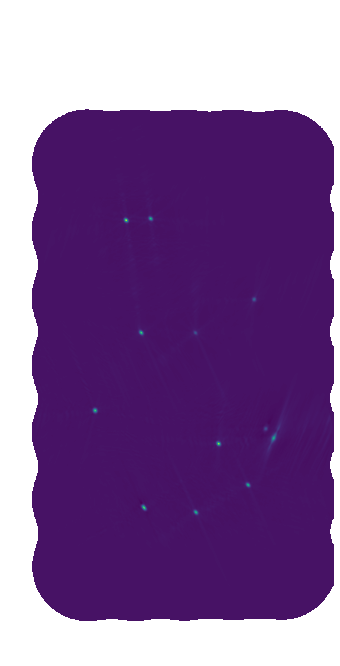

In [55]:
import matplotlib.pyplot as plt
data1 = data[:, :, 0, 0].copy()
pb1 = img_xds.PB[:,:, 0, 0, 0].values
data1[pb1<pb_limit] = np.nan

(-0.5, 799.5, 1599.5, -0.5)

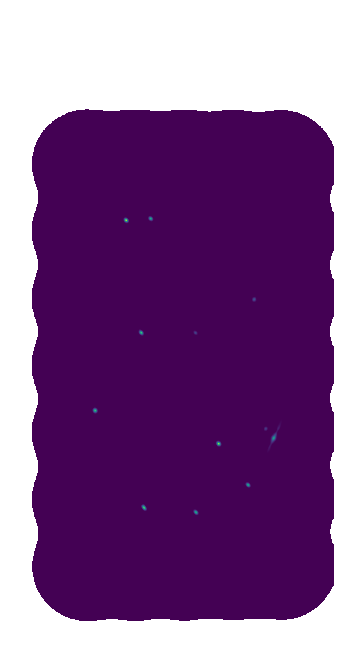

In [57]:
plt.figure(figsize = (12, 12))
#plt.imshow(img_xds.IMAGE.isel(chan=chan,time=0,pol=0))
plt.imshow(data1, vmin = 0.1)
plt.axis("off")

In [21]:
print(mosaic_img[:, :, 0, 0])

<xarray.DataArray 'IMAGE' (l: 1600, m: 800)>
dask.array<getitem, shape=(1600, 800), dtype=float32, chunksize=(1600, 800), chunktype=numpy.ndarray>
Coordinates:
    chan             float64 3.4e+09
  * l                (l) float64 0.01939 0.01937 0.01934 ... -0.01934 -0.01937
  * m                (m) float64 -0.009696 -0.009672 ... 0.009648 0.009672
    pol              int64 5
    time             datetime64[ns] 2019-10-05T17:15:39.800061184
    chan_width       float64 dask.array<chunksize=(), meta=np.ndarray>
    right_ascension  (l, m) float64 1.014 1.014 1.014 ... 0.9713 0.9713 0.9713
    declination      (l, m) float64 0.4127 0.4127 0.4127 ... 0.432 0.432 0.432


In [121]:
test = point_source_ra_dec[0, :, 0]

In [122]:
test

array([0.99259056, 0.9999064 , 0.98753638, 0.98535472, 0.98120229])

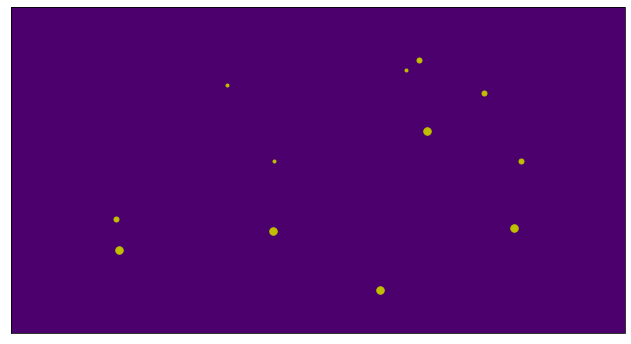

In [162]:
plt.figure(figsize = (11, 6))
ax = plt.gca()
ax.set_facecolor('xkcd:royal purple')
plt.plot(-point_source_ra_dec[0, -5:, 0], point_source_ra_dec[0, -5:, 1], ".y", ms=15)
plt.plot(-point_source_ra_dec[0, -9:-5, 0], point_source_ra_dec[0, -9:-5, 1], ".y", ms = 10)
plt.plot(-point_source_ra_dec[0, :, 0], point_source_ra_dec[0, :, 1], ".y")
plt.xlim(-1.005, -0.976)
plt.ylim(.416, .431)
#plt.axis("equal")
plt.xticks([])
plt.yticks([])
plt.show()